This notebook deals with the basics of Only Transformer Model - Dark horse of LLM models
* https://github.com/karpathy/nanoGPT/tree/master
* https://github.com/karpathy/nanoGPT/tree/master
* https://github.com/karpathy/nanoGPT/tree/master
* https://www.kaggle.com/code/heyytanay/pytorch-lightning-gpt-pre-training-w-b
* https://mukherjeesrijit.substack.com/p/code-your-gpt2-architecture-from
* https://cameronrwolfe.substack.com/p/decoder-only-transformers-the-workhorse

In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/EraV2_Transformers"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run2/code/Users/soutrik.chowdhury/EraV2_Transformers


In [3]:
import os
import json
import regex as re
import requests
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import pickle
import math
import time
from collections import defaultdict
import tiktoken
from torch.nn import functional as F
from torchinfo import summary
from tqdm import tqdm

#### Data Preparation 

In [4]:
# We will work with tinyshakespeare dataset

data_dr = os.path.join(os.getcwd(), "data", "tinyshakespeare")
os.makedirs(data_dr, exist_ok=True)
input_path = os.path.join(data_dr, "input.txt")

if not os.path.exists(input_path):
    data_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    with open(input_path, "w") as f:
        f.write(requests.get(data_url).text)

In [5]:
with open(input_path, "r") as f:
    text = f.read()

print(len(text))  # 1.1 millions characters

1115394


In [6]:
# train val split
train_text = text[: int(0.9 * len(text))]
val_text = text[int(0.9 * len(text)):]

print(len(train_text), len(val_text))

1003854 111540


In [7]:
# Encoding with gpt2 tokenizer
enc = tiktoken.get_encoding(encoding_name="gpt2")
train_ids = enc.encode_ordinary(train_text)
val_ids = enc.encode_ordinary(val_text)

In [8]:
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

train has 301,966 tokens
val has 36,059 tokens


In [9]:
# export to bin file for faster loading
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)

train_ids.tofile(os.path.join(data_dr, "train.bin"))
val_ids.tofile(os.path.join(data_dr, "val.bin"))

In [10]:
# enc.decode(train_ids[:100])
# enc.decode_batch([train_ids[:100]])

#### Model Config - Setting up hyperparameters as per machine capacity
* vocab_size: the size of the vocabulary
* n_layer: the number of layers in the modeln_layer: the number of layers in the model
* n_head: the number of attention heads in each layer
* n_embd: the size of the embedding layer
* embd_pdrop: dropout probability for the embedding layer
* resid_pdrop: dropout probability for the residual connections
* attn_pdrop: dropout probability for the attention weights
* dropout: global dropout probability
* compile: whether to use torch.compile, the latest method to speed up your PyTorch code (only for torch version > 2.0
* device: device to use for training (‘cpu’ or ‘cuda’)
* num_workers: an integer representing the number of worker threads to use for data loading.
* max_iters: maximum number of training iterations.
* batch_size: size of the batches to use during training
* block_size: the maximum length of the input sequences
* learning_rate: learning rate for the optimizer
* betas: tuple of two floats for the beta values for the Adam optimizer
* weight_Decay: weight decay for the optimizer
* grad_norm_clip: the maximum norm for the gradient during training
* dtype : Optimal dtype

In [11]:
class GPTConfig:
    """base GPT config"""

    def __init__(self, vocab_size, **kwargs):
        self.vocab_size = vocab_size
        for k, v in kwargs.items():
            setattr(self, k, v)


class CustomConfig(GPTConfig):
    n_layer = 8
    n_head = 8
    n_embd = 768
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1
    dropout = 0.1
    compile = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device_type = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers = 0  # 4 * torch.cuda.device_count()
    max_iters = 2e4
    batch_size = 16
    block_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    weight_decay = 0.1
    grad_norm_clip = 1.0
    dtype = (
        "bfloat16"
        if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
        else "float16"
    )  # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
    flash_attention = False
    mlp_heads = 2048
    bias = False

In [12]:
model_config = CustomConfig(vocab_size=50304)
print(model_config.dtype)

float16


#### Data Loaders using custom Pytorch Datasets

In [13]:
train_data = np.memmap(os.path.join(
    data_dr, "train.bin"), dtype="uint16", mode="r")
valid_data = np.memmap(os.path.join(data_dr, "val.bin"),
                       dtype="uint16", mode="r")

In [14]:
print(
    f"the type is {type(train_data)} and no of elements are {train_data.size}")
print(
    f"the type is {type(valid_data)} and no of elements are {valid_data.size}")

the type is <class 'numpy.memmap'> and no of elements are 301966
the type is <class 'numpy.memmap'> and no of elements are 36059


In [15]:
class SakespeareDataset(Dataset):
    def __init__(self, split, block_size, device_type):
        assert split in [
            "train", "valid"], "split should be either train or valid"
        self.split = split
        self.block_size = block_size
        self.device_type = device_type
        self.data = (
            train_data if split == "train" else valid_data
        )  # global variable train_data and valid_data

    def __len__(self):
        return (
            len(self.data) - self.block_size
        )  # iterate till the end of the data - block_size

    def __getitem__(self, index):

        x = torch.from_numpy(
            self.data[index: index + self.block_size].astype(np.int64)
        ).long()  # input sequence of block_size
        y = torch.from_numpy(
            self.data[index + 1: index + self.block_size + 1].astype(np.int64)
        ).long()  # target sequence of block_size shifted by 1 position to the right

        if self.device_type == "cuda":
            x = x.pin_memory().to(
                self.device_type, non_blocking=True
            )  # pin_memory is used to speed up the transfer of data from cpu to gpu
            y = y.pin_memory().to(
                self.device_type, non_blocking=True
            )  # non_blocking=True is used to make the transfer async

        else:
            x = x.to(self.device_type)
            y = y.to(self.device_type)

        return x, y

In [16]:
train_dataset = SakespeareDataset(
    "train", model_config.block_size, model_config.device)
valid_dataset = SakespeareDataset(
    "valid", model_config.block_size, model_config.device)

In [17]:
print(next(iter(train_dataset)))

(tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,
         3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248,
          461,    11,  2740,    13,   198,   198,  5962, 22307,    25,   198,
         1639,   389,   477, 12939,  2138,   284,  4656,   621,   284,  1145,
          680,    30,   198,   198,  3237,    25,   198,  4965,  5634,    13,
        12939,    13,   198,   198,  5962, 22307,    25,   198,  5962,    11,
          345,   760,   327,  1872], device='cuda:0'), tensor([22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,  3285,
          502,  2740,    13,   198,   198,  3237,    25,   198,  5248,   461,
           11,  2740,    13,   198,   198,  5962, 22307,    25,   198,  1639,
          389,   477, 12939,  2138,   284,  4656,   621,   284,  1145,   680,
           30,   198,   198,  3237,    25,   198,  4965,  5634,    13, 12939,
           13,   198,   198,  5962, 22307,    25,   198,  5962,    11,   345,
        

In [18]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=model_config.batch_size,
    num_workers=0,  # 0 because of  all ready pin_memory is used
    drop_last=False,
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=model_config.batch_size,
    num_workers=0,
    drop_last=False,
)

In [19]:
# batches of 4 which has sequences of 64 tokens
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

for x, y in valid_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([16, 64]) torch.Size([16, 64])
torch.Size([16, 64]) torch.Size([16, 64])


#### Model Code

GELU Activatiom Function

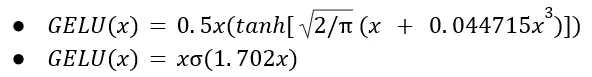

In [20]:
class NewGELU(nn.Module):
    """Gaussian Error Linear Units (GELU)"""

    def forward(self, x):
        return (
            0.5
            * x
            * (
                1
                + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3)))
            )
        )

Causal Self Attention

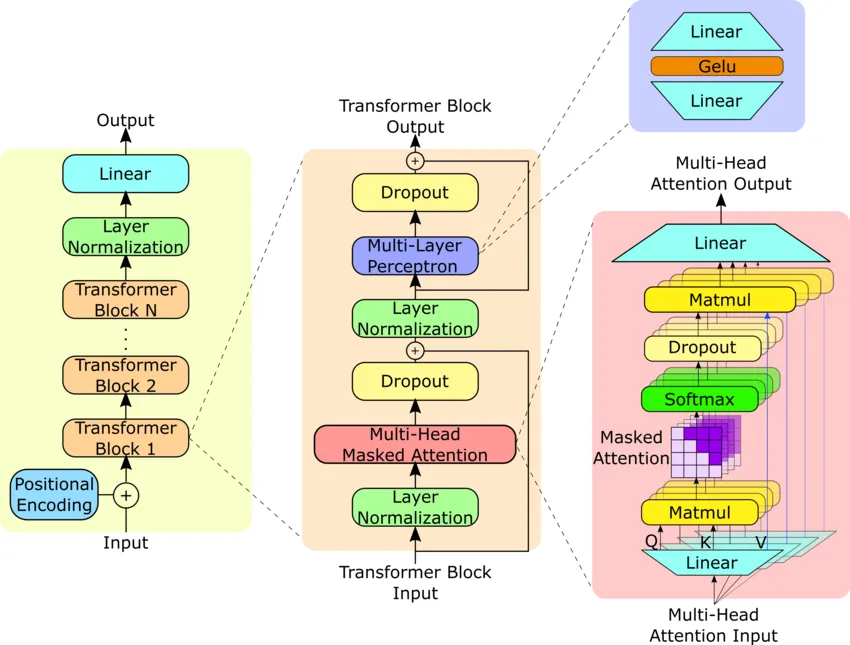

In [21]:
class CausalSelfAttention(nn.Module):
    """A vanilla multi-head masked self-attention layer with a projection at the end"""

    def __init__(self, config, training) -> None:
        super().__init__()
        assert (
            config.n_embd % config.n_head == 0
        ), "n_embd must be divisible by n_head"  # embedding size is divisible by the number of heads

        # key query and value are all of shape (seq_len, n_embd)
        self.c_attn_q = nn.Linear(
            config.n_embd, config.n_embd, bias=False
        )  # linear layer for key, query and value

        self.c_attn_k = nn.Linear(config.n_embd, config.n_embd, bias=False)

        self.c_attn_v = nn.Linear(config.n_embd, config.n_embd, bias=False)
        # outout projection layer
        # linear layer for output
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=False)

        # regularizations
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.dropout = config.dropout
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.d_k = config.n_embd // config.n_head

        # flash attention if applicable else normal attention
        self.flash = (
            hasattr(torch.nn.functional, "scaled_dot_product_attention")
            and config.flash_attention
        )

        self.training = training

        if not self.flash:
            print("Using normal attention without flash support")
            mask = torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            )  # mask of dimensions (1, 1, block_size, block_size)
            self.register_buffer("mask", mask)

    def forward(self, input_x):
        #  Input is of size (batch_size, block_size, n_embd) ie (b, t, c)
        B, T, C = input_x.size()
        # print("The input shape is ", input_x.shape)

        # calculate query, key and value (batch_size, block_size, n_embd) -> (batch_size, block_size, 3 * n_embd) -> (batch_size, block_size, n_embd) * 3
        q = self.c_attn_q(input_x)  # (b, t, c)
        k = self.c_attn_k(input_x)  # (b, t, c)
        v = self.c_attn_v(input_x)  # (b, t, c)

        # now we need to split the query, key and value into n_head parts and same dim operation for each (batch_size, n_heads, block_size,head_dim)
        # (batch_size, block_size, n_embd) -> (batch_size, block_size, n_heads, head_dim) -> (batch_size, n_heads, block_size, head_dim)
        q = q.view(B, T, self.n_head, self.d_k).transpose(1, 2)  # (b, h, t, d)
        k = k.view(B, T, self.n_head, self.d_k).transpose(1, 2)  # (b, h, t, d)
        v = v.view(B, T, self.n_head, self.d_k).transpose(1, 2)  # (b, h, t, d)

        # causal self attention: q*v^T/sqrt(d_k) -> softmax -> v * softmax(q*v^T/sqrt(d_k))
        # (batch_size, n_heads, block_size, head_dim) * (batch_size, n_heads, block_size, head_dim)^T -> (batch_size, n_heads, block_size, block_size) (key query dot product)
        # After scaled calculation of masked softmax -> (batch_size, n_heads, block_size, block_size)
        # Finally multiply with value -> (batch_size, n_heads, block_size, block_size) * (batch_size, n_heads, block_size, head_dim) -> (batch_size, n_heads, block_size, head_dim)

        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            # print("Using Flash Attention")
            y = torch.nn.functional.scaled_dot_product_attention(
                query=q,
                key=k,
                value=v,
                dropout=self.dropout if self.training else 0,
                is_causal=True,
            )

        else:
            # print("Using normal attention")
            # query * key^T / sqrt(d_k) -> (b,h,t,d) * (b,h,t,d)^T -> (b,h,t,t)
            att = q @ k.transpose(-2, -1)

            # scaling the dot product
            att = att / math.sqrt(self.d_k)

            # adding mask filling operation - in the mask to prevent data leakage from future tokens we fill the upper triangle with -inf
            att = att.masked_fill(
                self.mask[:, :, :T, :T] == 0, float("-inf")
            )  # (b,h,t,t)
            att = F.softmax(att, dim=-1)  # (b,h,t,t)

            # apply dropout
            att = self.attn_dropout(att)

            # attention * value -> (b,h,t,t) * (b,h,t,d) -> (b,h,t,d)
            y = att @ v

        # the op should be of shape (batch_size, block_size, n_embd) ie same as input
        # (b,h,t,d) ->(b,t,h,d) -> (b,t,c)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # application of projection layer
        y = self.c_proj(y)  # (b,t,c)

        # residual dropout -- apply dropout to the output of the projection layer included into this layer itself
        y = self.resid_dropout(y)

        return y

In [22]:
# input_x = torch.randint(0, 50304, (4, 64, 512), dtype=torch.float32, device=model_config.device)
# causal_self_attention = CausalSelfAttention(model_config, training=True).to(model_config.device)
# output = causal_self_attention(input_x)
# print(output.shape)

Layer Norm Block and MLP Block

In [23]:
class LayerNorm(nn.Module):
    """LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False"""

    def __init__(self, ndim):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if model_config.bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [24]:
class MLP(nn.Module):
    """Simple linear transformation with GELU activation and dropout"""

    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.n_embd, config.mlp_heads, bias=False)
        self.gelu = NewGELU()
        self.linear_2 = nn.Linear(config.mlp_heads, config.n_embd, bias=False)
        self.dropout = nn.Dropout(
            config.resid_pdrop
        )  # dropout layer for residual connection

    def forward(self, input):
        x = self.linear_1(input)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

Decoder Block

* Embedded Input -> LayerNorm-> Self Attention -> Residual Connection

* Output from Self Attention -> LayerNorm -> MLP -> Residual Connection

We are using Pre layer Normalization which is very common in Decoder only models

In [25]:
class DecoderBlock(nn.Module):
    """Transformer decoder block"""

    def __init__(self, config, training: bool):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd)
        self.ln_2 = LayerNorm(config.n_embd)
        self.c_attn = CausalSelfAttention(config, training)
        self.mlp = MLP(config)

    def forward(self, x):
        # print(f" The shape in decoder_block {x.shape}")
        x = x + self.c_attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))

        return x

Vanilla GPT model

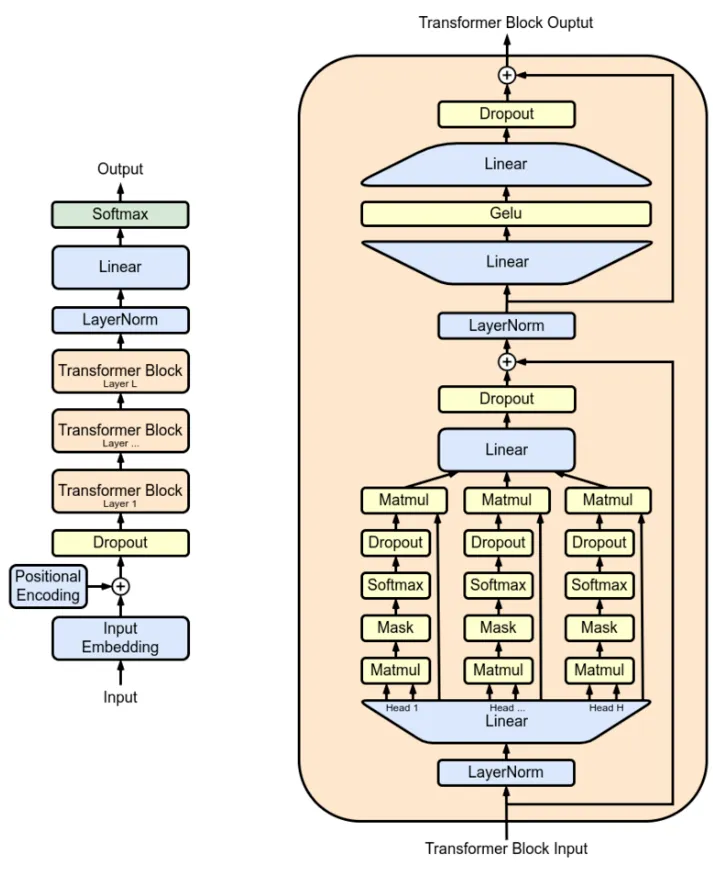

GPT Module
* Token embedding Layer
* Postional Embedding Layer
* Transformer Blocks
* Fnal Linear layer

In [26]:
class GPT(nn.Module):

    def __init__(self, config, training: bool = True):
        super(GPT, self).__init__()
        self.block_size = config.block_size

        # transformer layers
        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embd),
                wpe=nn.Embedding(config.block_size, config.n_embd),
                drop=nn.Dropout(config.embd_pdrop),
                heads=nn.ModuleList(
                    [DecoderBlock(config, training) for _ in range(config.n_layer)]
                ),
                ln_f=LayerNorm(config.n_embd),
            )
        )

        # language model head
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # initialize weights
        self.apply(self._init_weights)

        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith("c_proj.weight"):
                torch.nn.init.normal_(
                    p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer)
                )

        # print number of parameters
        print(
            f"Number of parameters in GPT model: {self._calc_transformer_params(self.transformer)}"
        )

    @staticmethod
    def _init_weights(module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    @staticmethod
    def _calc_transformer_params(transformer):
        return sum(p.numel() for p in transformer.parameters())

    def forward(self, input_ids, target=None):
        input_ids = input_ids.long()
        b, t = input_ids.size()  # batch size and sequence length

        # print(f"the input size is {input_ids.shape}")
        assert (
            t <= self.block_size
        ), "Cannot forward as the input sequence length is greater than block size"

        # create input for positional token embeddings
        pos = torch.arange(0, t, dtype=torch.long, device=input_ids.device).unsqueeze(
            0
        )  # (1, t) sequence of integers from 0 to t

        # create the embedding block
        tok_embd = self.transformer.wte(input_ids)  # (b, t, n_embd)
        # print(f"the token embedding size is {tok_embd.shape}")
        # create the positional embeddings
        pos_embd = self.transformer.wpe(pos)  # (1, t, n_embd)
        # print(f"the positional embedding size is {pos_embd.shape}")

        # add the two embeddings
        x = tok_embd + pos_embd  # (b, t, n_embd) + (1, t, n_embd) -> (b, t, n_embd)

        # print(f"the sum of token and positional embedding size is {x.shape}")

        # application of dropout
        x = self.transformer.drop(x)

        # application of transformer layers
        for layer in self.transformer.heads:
            x = layer(x)  # (b, 1, n_embd)

        # print(f"the transformer output size is {x.shape}")
        # apply layer norm
        x = self.transformer.ln_f(x)

        # print(f"the layer norm output size is {x.shape}")

        loss = None
        if target is not None:
            # calculate the logits
            logits = self.lm_head(x)
            # calculate the loss
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), target.view(-1), ignore_index=-1
            )
            return logits, loss
        else:
            # only take the last layer for each batch as input to the language model head
            logits = self.lm_head(x[:, [-1], :])  # (b, 1, vocab_size)
            return logits, loss

In [27]:
transformer_model = GPT(model_config).to(model_config.device)

Using normal attention without flash support
Using normal attention without flash support
Using normal attention without flash support
Using normal attention without flash support
Using normal attention without flash support
Using normal attention without flash support
Using normal attention without flash support
Using normal attention without flash support
Number of parameters in GPT model: 82735872


In [28]:
print(transformer_model)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(64, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (heads): ModuleList(
      (0-7): 8 x DecoderBlock(
        (ln_1): LayerNorm()
        (ln_2): LayerNorm()
        (c_attn): CausalSelfAttention(
          (c_attn_q): Linear(in_features=768, out_features=768, bias=False)
          (c_attn_k): Linear(in_features=768, out_features=768, bias=False)
          (c_attn_v): Linear(in_features=768, out_features=768, bias=False)
          (c_proj): Linear(in_features=768, out_features=768, bias=False)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (mlp): MLP(
          (linear_1): Linear(in_features=768, out_features=2048, bias=False)
          (gelu): NewGELU()
          (linear_2): Linear(in_features=2048, out_features=768, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_

In [29]:
# random_tensor = torch.randint(0, 100, (3, 3, 11))
# print(random_tensor.shape)
# print(random_tensor[:, [-1], :].shape)

In [30]:
# random_tensor = torch.randint(0, 100, (3, 1, 11))
# random_tensor.view(-1, random_tensor.size(-1)).shape
# random_tensor.squeeze(1).shape
# random_tensor = torch.randint(0, 100, (3, 1, 11))
# random_tensor.view(-1).shape

Small Testing of the model

In [31]:
# input_b = torch.randint(
#     low=0,
#     high=model_config.vocab_size,
#     size=(model_config.batch_size, model_config.block_size),
# ).to(model_config.device)
# print(input_b.shape)

In [32]:

# transformer_model.eval()
# output, loss = transformer_model(input_b)
# print(output.shape)

Optimizer setup -- Will cover this in more details while we read in NanoGpt:  https://www.youtube.com/watch?v=l8pRSuU81PU&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=10

In [33]:
import inspect


def configure_optimizers(model, config):
    """Optimizers for training the model as per Karpathy's blog"""
    # start with all of the candidate parameters
    param_dict = {pn: p for pn, p in model.named_parameters()}
    # filter out those that do not require grad
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {"params": decay_params, "weight_decay": config.weight_decay},
        {"params": nodecay_params, "weight_decay": 0.0},
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    print(
        f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
    )
    print(
        f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
    )
    # Create AdamW optimizer and use the fused version if it is available
    fused_available = "fused" in inspect.signature(torch.optim.AdamW).parameters
    use_fused = fused_available and config.device_type == "cuda"
    extra_args = dict(fused=True) if use_fused else dict()
    optimizer = torch.optim.AdamW(
        optim_groups, lr=config.learning_rate, betas=config.betas, **extra_args
    )
    print(f"using fused AdamW: {use_fused}")

    return optimizer

In [34]:
optimizer = configure_optimizers(transformer_model, model_config)

num decayed parameter tensors: 51, with 121,356,288 parameters
num non-decayed parameter tensors: 17, with 13,056 parameters


using fused AdamW: True


In [35]:
# This is another way to configure the optimizer in another way as shared in minigpt - https://github.com/soutrik71/minGPT/blob/master/mingpt/model.py
# def configure_optimizers(train_config):
#     """
#     This long function is unfortunately doing something very simple and is being very defensive:
#     We are separating out all parameters of the model into two buckets: those that will experience
#     weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
#     We are then returning the PyTorch optimizer object.
#     """

#     # separate out all parameters to those that will and won't experience regularizing weight decay
#     decay = set()
#     no_decay = set()
#     whitelist_weight_modules = (torch.nn.Linear, )
#     blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
#     for mn, m in self.named_modules():
#         for pn, p in m.named_parameters():
#             fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
#             # random note: because named_modules and named_parameters are recursive
#             # we will see the same tensors p many many times. but doing it this way
#             # allows us to know which parent module any tensor p belongs to...
#             if pn.endswith('bias'):
#                 # all biases will not be decayed
#                 no_decay.add(fpn)
#             elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
#                 # weights of whitelist modules will be weight decayed
#                 decay.add(fpn)
#             elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
#                 # weights of blacklist modules will NOT be weight decayed
#                 no_decay.add(fpn)

#     # validate that we considered every parameter
#     param_dict = {pn: p for pn, p in self.named_parameters()}
#     inter_params = decay & no_decay
#     union_params = decay | no_decay
#     assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
#     assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
#                                                 % (str(param_dict.keys() - union_params), )

#     # create the pytorch optimizer object
#     optim_groups = [
#         {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
#         {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
#     ]
#     optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
#     return optimizer

In [36]:
if model_config.compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = transformer_model
    model = torch.compile(transformer_model)  # requires PyTorch 2.0

compiling the model... (takes a ~minute)


/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [37]:
from contextlib import nullcontext

torch.manual_seed(1337)
torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
# note: float16 data type will automatically use a GradScaler
ptdtype = {
    "float32": torch.float32,
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
}[model_config.dtype]

# context manager to use mixed precision
ctx = (
    nullcontext()
    if model_config.device_type == "cpu"
    else torch.amp.autocast(device_type=model_config.device_type, dtype=ptdtype)
)

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler()

In [38]:
class BasicTrainer:
    """Basic Model Trainer as per Karpathy's blog on MiniGPT"""

    def __init__(self, config, model, optimizer, train_dataloader):
        self.config = config
        self.model = model
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.callbacks = defaultdict(list)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_num = 0
        self.iter_time = 0.0

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def run(self):
        # setting up the basics
        model, config = self.model, self.config
        train_dataloader = self.train_dataloader
        start_time = time.time()
        # set the model to train mode
        model.train()
        self.iter_num = 0
        data_iter = iter(train_dataloader)

        while True:
            # get the batch data
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_dataloader)
                batch = next(data_iter)

            # set the device
            batch = [t.to(config.device) for t in batch]
            X, y = batch
            # print(f"the input size is {X.shape}")
            # print(f"the target size is {y.shape}")

            # forward the model
            logits, self.loss = model(X, y)

            # backprop and optimzier
            optimizer.zero_grad(set_to_none=True)
            self.loss.backward()

            # gradient clipping
            if config.grad_norm_clip is not None:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), config.grad_norm_clip
                )
            # optimizer step
            self.optimizer.step()

            self.trigger_callbacks("on_batch_end")
            self.iter_num += 1
            elapsed = time.time() - start_time
            self.iter_time += elapsed

            # termination conditions
            if config.max_iters is not None and self.iter_num >= config.max_iters:
                break

In [39]:
trainer = BasicTrainer(model_config, transformer_model, optimizer, train_dataloader)

In [40]:
def batch_end_callback(trainer):
    if trainer.iter_num % 500 == 0:
        # print the loss at every 500th iteration
        print(
            f"iter_dt {trainer.iter_time * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}"
        )

# add the callback to the trainer
trainer.set_callback("on_batch_end", batch_end_callback)
trainer.run()

iter_dt 0.00ms; iter 0: train loss 10.90146
iter_dt 8050140.87ms; iter 500: train loss 4.76696
iter_dt 31460677.36ms; iter 1000: train loss 5.68873
iter_dt 70251525.17ms; iter 1500: train loss 5.25030
iter_dt 124422844.02ms; iter 2000: train loss 4.28506
iter_dt 193974725.57ms; iter 2500: train loss 5.57762


KeyboardInterrupt: 

Actual Code of GPT by Karpathy

In [79]:
# import math
# import inspect
# from dataclasses import dataclass

# import torch
# import torch.nn as nn
# from torch.nn import functional as F


# class LayerNorm(nn.Module):
#     """LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False"""

#     def __init__(self, ndim, bias):
#         super().__init__()
#         self.weight = nn.Parameter(torch.ones(ndim))
#         self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

#     def forward(self, input):
#         return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)


# class CausalSelfAttention(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         assert config.n_embd % config.n_head == 0
#         # key, query, value projections for all heads, but in a batch
#         self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
#         # output projection
#         self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
#         # regularization
#         self.attn_dropout = nn.Dropout(config.dropout)
#         self.resid_dropout = nn.Dropout(config.dropout)
#         self.n_head = config.n_head
#         self.n_embd = config.n_embd
#         self.dropout = config.dropout
#         # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
#         self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention")
#         if not self.flash:
#             print(
#                 "WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0"
#             )
#             # causal mask to ensure that attention is only applied to the left in the input sequence
#             self.register_buffer(
#                 "bias",
#                 torch.tril(torch.ones(config.block_size, config.block_size)).view(
#                     1, 1, config.block_size, config.block_size
#                 ),
#             )

#     def forward(self, x):
#         B, T, C = (
#             x.size()
#         )  # batch size, sequence length, embedding dimensionality (n_embd)
#         print(f"the input shape is {x.shape}")
#         # calculate query, key, values for all heads in batch and move head forward to be the batch dim
#         q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        
#         print(f"the query shape is {q.shape}")
#         k = k.view(B, T, self.n_head, C // self.n_head).transpose(
#             1, 2
#         )  # (B, nh, T, hs)
#         q = q.view(B, T, self.n_head, C // self.n_head).transpose(
#             1, 2
#         )  # (B, nh, T, hs)
#         v = v.view(B, T, self.n_head, C // self.n_head).transpose(
#             1, 2
#         )  # (B, nh, T, hs)

#         # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
#         if self.flash:
#             # efficient attention using Flash Attention CUDA kernels
#             y = torch.nn.functional.scaled_dot_product_attention(
#                 q,
#                 k,
#                 v,
#                 attn_mask=None,
#                 dropout_p=self.dropout if self.training else 0,
#                 is_causal=True,
#             )
#         else:
#             # manual implementation of attention
#             att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
#             att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
#             att = F.softmax(att, dim=-1)
#             att = self.attn_dropout(att)
#             y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
#         y = (
#             y.transpose(1, 2).contiguous().view(B, T, C)
#         )  # re-assemble all head outputs side by side

#         # output projection
#         y = self.resid_dropout(self.c_proj(y))
#         return y


# class MLP(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
#         self.gelu = nn.GELU()
#         self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
#         self.dropout = nn.Dropout(config.dropout)

#     def forward(self, x):
#         x = self.c_fc(x)
#         x = self.gelu(x)
#         x = self.c_proj(x)
#         x = self.dropout(x)
#         return x


# class Block(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
#         self.attn = CausalSelfAttention(config)
#         self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
#         self.mlp = MLP(config)

#     def forward(self, x):
#         x = x + self.attn(self.ln_1(x))
#         x = x + self.mlp(self.ln_2(x))
#         return x


# @dataclass
# class GPTConfig:
#     block_size: int = 1024
#     vocab_size: int = (
#         50304  # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
#     )
#     n_layer: int = 12
#     n_head: int = 12
#     n_embd: int = 768
#     dropout: float = 0.0
#     bias: bool = (
#         True  # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
#     )


# class GPT(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         assert config.vocab_size is not None
#         assert config.block_size is not None
#         self.config = config

#         self.transformer = nn.ModuleDict(
#             dict(
#                 wte=nn.Embedding(config.vocab_size, config.n_embd),
#                 wpe=nn.Embedding(config.block_size, config.n_embd),
#                 drop=nn.Dropout(config.dropout),
#                 h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
#                 ln_f=LayerNorm(config.n_embd, bias=config.bias),
#             )
#         )
#         self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
#         # with weight tying when using torch.compile() some warnings get generated:
#         # "UserWarning: functional_call was passed multiple values for tied weights.
#         # This behavior is deprecated and will be an error in future versions"
#         # not 100% sure what this is, so far seems to be harmless. TODO investigate
#         self.transformer.wte.weight = (
#             self.lm_head.weight
#         )  # https://paperswithcode.com/method/weight-tying

#         # init all weights
#         self.apply(self._init_weights)
#         # apply special scaled init to the residual projections, per GPT-2 paper
#         for pn, p in self.named_parameters():
#             if pn.endswith("c_proj.weight"):
#                 torch.nn.init.normal_(
#                     p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer)
#                 )

#         # report number of parameters
#         print("number of parameters: %.2fM" % (self.get_num_params() / 1e6,))

#     def get_num_params(self, non_embedding=True):
#         """
#         Return the number of parameters in the model.
#         For non-embedding count (default), the position embeddings get subtracted.
#         The token embeddings would too, except due to the parameter sharing these
#         params are actually used as weights in the final layer, so we include them.
#         """
#         n_params = sum(p.numel() for p in self.parameters())
#         if non_embedding:
#             n_params -= self.transformer.wpe.weight.numel()
#         return n_params

#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
#             if module.bias is not None:
#                 torch.nn.init.zeros_(module.bias)
#         elif isinstance(module, nn.Embedding):
#             torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

#     def forward(self, idx, targets=None):
#         device = idx.device
#         print(f"the input shape is {idx.shape}")
#         b, t = idx.size()
#         assert (
#             t <= self.config.block_size
#         ), f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
#         pos = torch.arange(0, t, dtype=torch.long, device=device)  # shape (t)

#         # forward the GPT model itself
#         tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
#         print(f"the token embedding shape is {tok_emb.shape}")
#         pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (t, n_embd)
#         print(f"the position embedding shape is {pos_emb.shape}")
#         x = self.transformer.drop(tok_emb + pos_emb)

#         print(f"the input shape after adding token and position embedding is {x.shape}")
#         for block in self.transformer.h:
#             x = block(x)
#         x = self.transformer.ln_f(x)

#         print(f"the output shape after transformer block is {x.shape}")

#         if targets is not None:
#             # if we are given some desired targets also calculate the loss
#             logits = self.lm_head(x)
#             loss = F.cross_entropy(
#                 logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1
#             )
#         else:
#             # inference-time mini-optimization: only forward the lm_head on the very last position
#             logits = self.lm_head(
#                 x[:, [-1], :]
#             )  # note: using list [-1] to preserve the time dim
#             loss = None

#         return logits, loss

#     def crop_block_size(self, block_size):
#         # model surgery to decrease the block size if necessary
#         # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
#         # but want to use a smaller block size for some smaller, simpler model
#         assert block_size <= self.config.block_size
#         self.config.block_size = block_size
#         self.transformer.wpe.weight = nn.Parameter(
#             self.transformer.wpe.weight[:block_size]
#         )
#         for block in self.transformer.h:
#             if hasattr(block.attn, "bias"):
#                 block.attn.bias = block.attn.bias[:, :, :block_size, :block_size]

#     @classmethod
#     def from_pretrained(cls, model_type, override_args=None):
#         assert model_type in {"gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"}
#         override_args = override_args or {}  # default to empty dict
#         # only dropout can be overridden see more notes below
#         assert all(k == "dropout" for k in override_args)
#         from transformers import GPT2LMHeadModel

#         print("loading weights from pretrained gpt: %s" % model_type)

#         # n_layer, n_head and n_embd are determined from model_type
#         config_args = {
#             "gpt2": dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
#             "gpt2-medium": dict(n_layer=24, n_head=16, n_embd=1024),  # 350M params
#             "gpt2-large": dict(n_layer=36, n_head=20, n_embd=1280),  # 774M params
#             "gpt2-xl": dict(n_layer=48, n_head=25, n_embd=1600),  # 1558M params
#         }[model_type]
#         print("forcing vocab_size=50257, block_size=1024, bias=True")
#         config_args["vocab_size"] = 50257  # always 50257 for GPT model checkpoints
#         config_args["block_size"] = 1024  # always 1024 for GPT model checkpoints
#         config_args["bias"] = True  # always True for GPT model checkpoints
#         # we can override the dropout rate, if desired
#         if "dropout" in override_args:
#             print(f"overriding dropout rate to {override_args['dropout']}")
#             config_args["dropout"] = override_args["dropout"]
#         # create a from-scratch initialized minGPT model
#         config = GPTConfig(**config_args)
#         model = GPT(config)
#         sd = model.state_dict()
#         sd_keys = sd.keys()
#         sd_keys = [
#             k for k in sd_keys if not k.endswith(".attn.bias")
#         ]  # discard this mask / buffer, not a param

#         # init a huggingface/transformers model
#         model_hf = GPT2LMHeadModel.from_pretrained(model_type)
#         sd_hf = model_hf.state_dict()

#         # copy while ensuring all of the parameters are aligned and match in names and shapes
#         sd_keys_hf = sd_hf.keys()
#         sd_keys_hf = [
#             k for k in sd_keys_hf if not k.endswith(".attn.masked_bias")
#         ]  # ignore these, just a buffer
#         sd_keys_hf = [
#             k for k in sd_keys_hf if not k.endswith(".attn.bias")
#         ]  # same, just the mask (buffer)
#         transposed = [
#             "attn.c_attn.weight",
#             "attn.c_proj.weight",
#             "mlp.c_fc.weight",
#             "mlp.c_proj.weight",
#         ]
#         # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
#         # this means that we have to transpose these weights when we import them
#         assert len(sd_keys_hf) == len(
#             sd_keys
#         ), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
#         for k in sd_keys_hf:
#             if any(k.endswith(w) for w in transposed):
#                 # special treatment for the Conv1D weights we need to transpose
#                 assert sd_hf[k].shape[::-1] == sd[k].shape
#                 with torch.no_grad():
#                     sd[k].copy_(sd_hf[k].t())
#             else:
#                 # vanilla copy over the other parameters
#                 assert sd_hf[k].shape == sd[k].shape
#                 with torch.no_grad():
#                     sd[k].copy_(sd_hf[k])

#         return model

#     def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
#         # start with all of the candidate parameters
#         param_dict = {pn: p for pn, p in self.named_parameters()}
#         # filter out those that do not require grad
#         param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
#         # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
#         # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
#         decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
#         nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
#         optim_groups = [
#             {"params": decay_params, "weight_decay": weight_decay},
#             {"params": nodecay_params, "weight_decay": 0.0},
#         ]
#         num_decay_params = sum(p.numel() for p in decay_params)
#         num_nodecay_params = sum(p.numel() for p in nodecay_params)
#         print(
#             f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
#         )
#         print(
#             f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
#         )
#         # Create AdamW optimizer and use the fused version if it is available
#         fused_available = "fused" in inspect.signature(torch.optim.AdamW).parameters
#         use_fused = fused_available and device_type == "cuda"
#         extra_args = dict(fused=True) if use_fused else dict()
#         optimizer = torch.optim.AdamW(
#             optim_groups, lr=learning_rate, betas=betas, **extra_args
#         )
#         print(f"using fused AdamW: {use_fused}")

#         return optimizer

#     def estimate_mfu(self, fwdbwd_per_iter, dt):
#         """estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS"""
#         # first estimate the number of flops we do per iteration.
#         # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
#         N = self.get_num_params()
#         cfg = self.config
#         L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd // cfg.n_head, cfg.block_size
#         flops_per_token = 6 * N + 12 * L * H * Q * T
#         flops_per_fwdbwd = flops_per_token * T
#         flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
#         # express our flops throughput as ratio of A100 bfloat16 peak flops
#         flops_achieved = flops_per_iter * (1.0 / dt)  # per second
#         flops_promised = 312e12  # A100 GPU bfloat16 peak flops is 312 TFLOPS
#         mfu = flops_achieved / flops_promised
#         return mfu

#     @torch.no_grad()
#     def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
#         """
#         Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
#         the sequence max_new_tokens times, feeding the predictions back into the model each time.
#         Most likely you'll want to make sure to be in model.eval() mode of operation for this.
#         """
#         for _ in range(max_new_tokens):
#             # if the sequence context is growing too long we must crop it at block_size
#             idx_cond = (
#                 idx
#                 if idx.size(1) <= self.config.block_size
#                 else idx[:, -self.config.block_size :]
#             )
#             # forward the model to get the logits for the index in the sequence
#             logits, _ = self(idx_cond)
#             # pluck the logits at the final step and scale by desired temperature
#             logits = logits[:, -1, :] / temperature
#             # optionally crop the logits to only the top k options
#             if top_k is not None:
#                 v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
#                 logits[logits < v[:, [-1]]] = -float("Inf")
#             # apply softmax to convert logits to (normalized) probabilities
#             probs = F.softmax(logits, dim=-1)
#             # sample from the distribution
#             idx_next = torch.multinomial(probs, num_samples=1)
#             # append sampled index to the running sequence and continue
#             idx = torch.cat((idx, idx_next), dim=1)

#         return idx

In [80]:
# model = GPT(GPTConfig()).to(model_config.device)
# input_b = torch.randint(
#     low=0,
#     high=model_config.vocab_size,
#     size=(model_config.batch_size, model_config.block_size),
# ).to(model_config.device)
# print(input_b.shape)
# model.eval()
# output, loss = model(input_b)
# output.shape
